# Long range dispersal model

This notebook simulates the evolution of a three-species system  with long-range dispersal.

Importing the necessary libraries:

In [1]:
import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import colormaps
from scipy.integrate import odeint
np.random.seed(0)

## Discrete-time model
### Finite population

We consider a model world that has $N$ available sites. The sites are occupied by three species, namely species $r$ (rock), $s$ (scissors) and $p$ (paper), which occur in the proportions $n_r$ , $n_s$ and $n_p$ (with $n_r + n_s + n_p = 1$). Two sites are chosen at each time-step. The occupant of the first replicates into the second with a given probability - individual of species $r$ can invade a species $s$ with probability $P_r$, a species $s$ invades a species $p$ with probability $P_s$, a species $p$ invades a species $r$ with probability $P_p$ and all other invasion probabilities are zero.

Defining a function to simulate the evolution of the system for a world with $N$ sites:

In [2]:
def simulate_finite_N(Pr, Ps, Pp, nr_init, ns_init, N=1000, epochs=100):
    '''
    Simulate the evolution of a population of three species over time
    on a model world that has N available sites.

    Parameters
    ----------
    Pr : float
        The probability that a species of type r invades a species of type s.
    Ps : float
        The probability that a species of type s invades a species of type p.
    Pp : float
        The probability that a species of type p invades a species of type r.
    nr_init : float
        The initial proportion of species r in the population.
    ns_init : float
        The initial proportion of species s in the population.
    N : int
        The number of sites.
    epochs : int
        The number of time units to simulate.
    '''

    def check_P(P):
        if P < 0 or P > 1:
            raise ValueError('Pr, Ps and Pp must be between 0 and 1')
        
    check_P(Pr)
    check_P(Ps)
    check_P(Pp)
    
    if nr_init + ns_init > 1:
        raise ValueError('Initial species proportions must be less than 1')
    
    if N < 1:
        raise ValueError('Number of sites must be at least 1')
    
    if epochs < 1:
        raise ValueError('Number of steps must be at least 1')
    
    sites = numpy.zeros(N)

    nr = []
    ns = []
    np = []

    r_id = 1
    s_id = 2
    p_id = 3

    # Initialize the sites
    for i in range(N):
        sites[i] = numpy.random.choice([r_id, s_id, p_id], p=[nr_init, ns_init, 1-nr_init-ns_init])

    nr.append(numpy.sum(sites == r_id) / N)
    ns.append(numpy.sum(sites == s_id) / N)
    np.append(numpy.sum(sites == p_id) / N)

    for t in range(1, epochs):
        for step in range(N):
            # choose two random sites
            i = numpy.random.randint(0, N)
            j = numpy.random.randint(0, N)
            
            if sites[i] == r_id and sites[j] == s_id: # rock beats scissors
                if numpy.random.rand() < Pr:
                    sites[j] = r_id
            elif sites[i] == s_id and sites[j] == p_id: # scissors beats paper
                if numpy.random.rand() < Ps:
                    sites[j] = s_id
            elif sites[i] == p_id and sites[j] == r_id: # paper beats rock
                if numpy.random.rand() < Pp:
                    sites[j] = p_id
        
        nr.append(numpy.sum(sites == r_id) / N)
        ns.append(numpy.sum(sites == s_id) / N)
        np.append(numpy.sum(sites == p_id) / N)

        # if two species go extinct, stop the simulation
        if sum([numpy.isclose(nr[-1], 0, 1e-4),
                numpy.isclose(ns[-1], 0, 1e-4),
                numpy.isclose(np[-1], 0, 1e-4)
            ]) >= 2:
            break
    
    return pd.DataFrame({'$n_r$': nr, '$n_s$': ns, '$n_p$': np})

Defining functions to plot the evolution of the system:

In [3]:
def line_plot_species_evolution(df, title=None, show_markers=True):
    '''
    Plot the evolution of species proportions over time in a line plot.

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing the species proportions over time.
    title : str
        The title of the plot.
    '''
    ax = df.plot(
        figsize=(12, 4),
        style='o-' if show_markers else '-', color=['tab:red', 'purple', 'gold'],
        title=title,
        xlabel='Time'
    );
    if show_markers:
        for line in ax.get_lines():
            line.set_markeredgecolor('black')

def phase_plot_species_evolution(df, title=None):
    '''
    Plot the evolution of species proportions over time in a phase plot.

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing the species proportions over time.
    title : str
        The title of the plot.
    '''
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)
    cmap = colormaps['Blues']
    colors = cmap(np.linspace(0, 1, (df[df.columns[0]].shape[0]-1))) 
    for i in range(3):
        axs[i].plot(df[df.columns[i]][0:-1], df[df.columns[i]][1:], '-', color='k', zorder=1)
        axs[i].scatter(df[df.columns[i]][0:-1], df[df.columns[i]][1:], c=colors, s=50, zorder=2, edgecolor='black')
        axs[i].set_title(df.columns[i])
    fig.suptitle(title);
    fig.tight_layout()

def ternary_plot_species_evolution(df, title=None, show_markers=True):
    '''
    Plot the evolution of species proportions over time in a ternary plot.
    
    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing the species proportions over time.
    title : str
        The title of the plot.
    '''
    fig = px.scatter_ternary(
        df,
        a=df.columns[2],
        b=df.columns[0],
        c=df.columns[1],
        color=df.index,
        color_continuous_scale='blues',
        size_max=10,
        title=title
    )
    if show_markers:
        fig.update_traces(mode='lines+markers', line=dict(color='black', width=1),
            marker=dict(symbol='circle', line=dict(width=1, color='black')))
    else:
        fig.update_traces(mode='lines', line=dict(color='black', width=1))
    fig.update_layout(coloraxis_colorbar=dict(title='Time'))
    fig.show('png')

Simulating the evolution of the system with $P_r = 0.2$, $P_s = 0.5$, $P_p = 0.3$, $N = 100$ initialized with population densities close to the fixed point ($n_r=0.5$, $n_s=0.3$, $n_p=0.2$):

In [4]:
fp_finite_N_df = simulate_finite_N(Pr=0.2, Ps=0.5, Pp=0.3, nr_init=0.5, ns_init=0.3, N=1000, epochs=1000)

Plotting the evolution of the system:

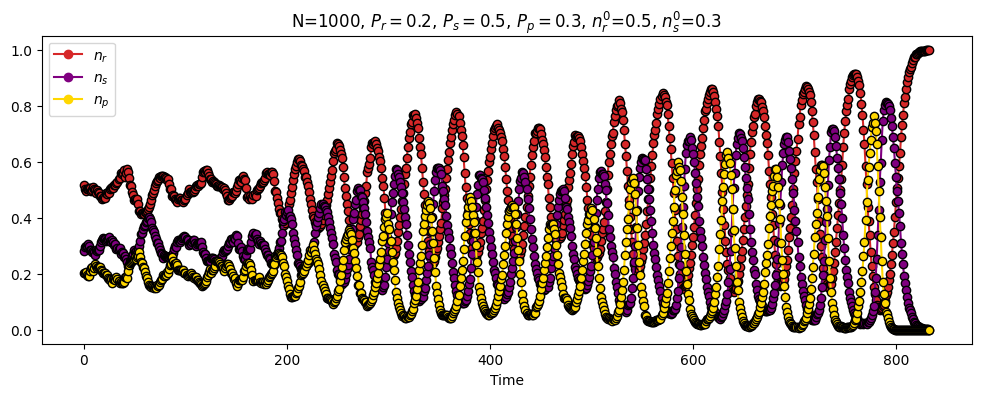

In [5]:
line_plot_species_evolution(
    fp_finite_N_df,
    title='N=1000, $P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=0.5, $n_s^0$=0.3'
)

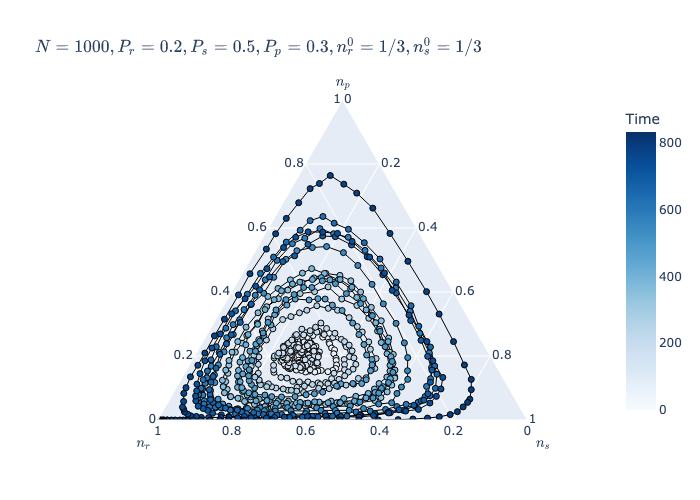

In [6]:
ternary_plot_species_evolution(
    fp_finite_N_df,
    title=r"$N=1000, P_r=0.2, P_s=0.5, P_p=0.3, n_r^0=1/3, n_s^0=1/3$"
)

In a finite world, the populations move from orbit to orbit, with two species (scissors and paper) eventually becoming extinct. The species that survives (rock) is the one that has the lowest invasion rate.

Performing simulations for a range of invasion probabilities chosen to sum to unity, initializing the population densities close to the fixed point and recording the surviving species:

In [7]:
# defining a grid of points for invasion probabilities
R, S = np.mgrid[0:1:20j, 0:1:20j]
R, S = R.ravel(), S.ravel()
P = 1 - R - S
I = np.array([R, S, P]).T
# keeping only invasion probabilities greater than 0.01
I = I[np.all(I > 0.01, axis=1)]
R = I[:, 0]
S = I[:, 1]
P = I[:, 2]
# total number of simulations to run
num_sim = len(I)
# number of sites 
N = 1000
# maximum number of iterations
EPOCHS = 2000
# list to store the winner of each simulation
winners = []

# iterating over the invasion probabilities
for i, (Pr, Ps, Pp) in enumerate(I):
    print(f"[{i+1}/{num_sim}] Running simulation for invasion probabilities: Pr={Pr:.2f}, Ps={Ps:.2f}, Pp={Pp:.2f}")
    # simulating with the current invasion probabilities
    results_df = simulate_finite_N(
        Pr=Pr, Ps=Ps, Pp=Pp,
        nr_init=Ps, ns_init=Pp,
        N=N, epochs=EPOCHS
    )
    # storing the winner
    if results_df.index.stop==EPOCHS: # no winner
        winners.append('None')
    elif np.isclose(results_df.iloc[-1]['$n_r$'], 1, 1e-4): # rock wins
            winners.append('Rock')
    elif np.isclose(results_df.iloc[-1]['$n_s$'], 1, 1e-4): # scissors wins
        winners.append('Scissors')
    else: # paper wins
        winners.append('Paper')

[1/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.05, Pp=0.89
[2/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.11, Pp=0.84
[3/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.16, Pp=0.79
[4/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.21, Pp=0.74
[5/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.26, Pp=0.68
[6/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.32, Pp=0.63
[7/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.37, Pp=0.58
[8/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.42, Pp=0.53
[9/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.47, Pp=0.47
[10/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.53, Pp=0.42
[11/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.58, Pp=0.37
[12/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.63, Pp=0.32
[13/153] Running simulati

Plotting the surviving species on a ternary plot:

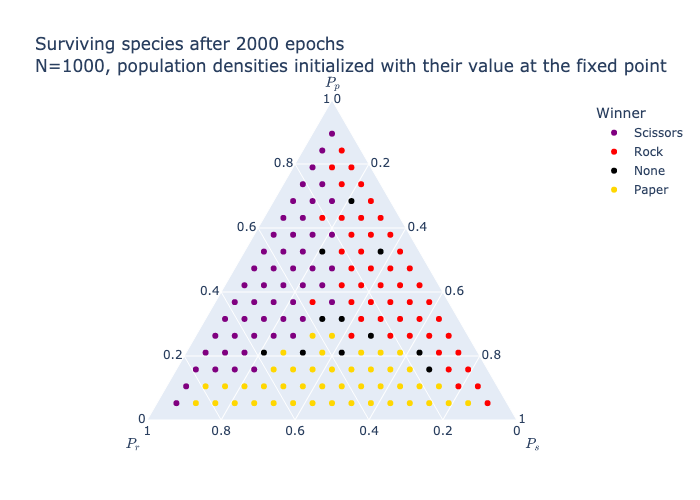

In [8]:
fig = px.scatter_ternary(
    pd.DataFrame(I, columns=['$P_r$', '$P_s$', '$P_p$']),
    a="$P_p$",
    b="$P_r$",
    c="$P_s$",
    size_max=10,
    title=f"Surviving species after {EPOCHS} epochs<br>N={N}, population densities initialized with their value at the fixed point",
    color = winners,
    color_discrete_map={'None': 'black', 'Rock': 'red', 'Scissors': 'purple', 'Paper': 'gold'}
    )
fig.update_layout(legend_title_text='Winner')
fig.show('png')

The weakest competitor is most likely to survive.

### Large population size

In the limit of large $N$, the rate of change of species population density is given by the mean-field equations:

\begin{cases}
\frac{\partial n_r}{\partial t}=n_r\cdot (n_s\cdot P_r - n_p \cdot P_p)\\
\frac{\partial n_s}{\partial t}=n_s\cdot (n_p\cdot P_s - n_r \cdot P_r)\\
\frac{\partial n_p}{\partial t}=n_p\cdot (n_r\cdot P_p - n_s \cdot P_s)\\
\end{cases}
Here a unit of time $t$ is $N$ individual time-steps, which we refer to as an epoch.

This leads to the following recurrence equations
$$n_r[t+1]=n_r[t] + n_r[t](n_s[t]P_r - n_p[t] P_p)$$
$$n_s[t+1]=n_s[t] + n_s[t](n_p[t]P_s - n_r[t] P_r)$$
$$n_p[t+1]=n_p[t] + n_p[t](n_r[t]P_p - n_s[t] P_s)$$

Defining a function to simulate the evolution of the system under the large $N$ assumption:

In [9]:
def simulate_large_N(Pr, Ps, Pp, nr_init, ns_init, delta_t=0.001, epochs=1000):
    '''
    Simulate the evolution of a population of three species over time using 
    the recurrence relations under the large N assumption.

    Parameters
    ----------
    Pr : float
        The probability that a species of type r invades a species of type s.
    Ps : float
        The probability that a species of type s invades a species of type p.
    Pp : float
        The probability that a species of type p invades a species of type r.
    nr_init : float
        The initial proportion of species r in the population.
    ns_init : float
        The initial proportion of species s in the population.
    delta_t : float
        The time step size.
    epochs : int
        The number of time units to simulate.
    '''

    def check_P(P):
        if P < 0 or P > 1:
            raise ValueError('Pr, Ps and Pp must be between 0 and 1')
        
    check_P(Pr)
    check_P(Ps)
    check_P(Pp)
    
    if nr_init + ns_init > 1:
        raise ValueError('Initial species proportions must be less than 1')
    
    if epochs < 1:
        raise ValueError('Number of steps must be at least 1')
    
    nr = []
    ns = []
    np = []

    nr.append(nr_init)
    ns.append(ns_init)
    np.append(1 - nr_init - ns_init)

    for _ in range(0, epochs-1):
        nr.append(nr[-1] + nr[-1]*delta_t*(ns[-1]*Pr - np[-1]*Pp))
        ns.append(ns[-1] + ns[-1]*delta_t*(np[-1]*Ps - nr[-2]*Pr)) # use nr from the previous time step
        np.append(1 - nr[-1] - ns[-1])

        # if two species go extinct, stop the simulation
        if sum([numpy.isclose(nr[-1], 0, 1e-4),
                numpy.isclose(ns[-1], 0, 1e-4),
                numpy.isclose(np[-1], 0, 1e-4)]) >= 2:
            break
    
    return pd.DataFrame({'$n_r$': nr, '$n_s$': ns, '$n_p$': np})

Trivial fixed points of the system are ($n_r=0, n_s=0, n_p=1$), ($n_r=0, n_s=1, n_p=0$) and ($n_r=1, n_s=0, n_p=0$).

The non-trivial fixed point is obtained by setting the rates of change to zero:

\begin{cases}
\frac{\partial n_r}{\partial t}=n_r\cdot (n_s\cdot P_r - n_p \cdot P_p)=0 \implies n_p = \frac{n_s\cdot P_r}{P_p}&\text{(1)}\\
\frac{\partial n_s}{\partial t}=n_s\cdot (n_p\cdot P_s - n_r \cdot P_r)=0 \implies n_r = \frac{n_p\cdot P_s}{P_r}&\text{(2)}\\
n_r+n_s+n_p=1 \implies n_s = 1-n_p-n_r&\text{(3)}\\
\end{cases}

$$\implies$$

\begin{cases}
n_r = \frac{n_s \cdot \cancel{P_r}\cdot P_s}{P_p\cdot \cancel{P_r}}&\text{(4), substituting (1) into (2)}\\
n_s = 1-\frac{n_s\cdot P_r}{P_p}-nr&\text{(5), substituting (1) into (3)}\\
\end{cases}

$$\implies$$

\begin{cases}
n_s=1-\frac{n_s\cdot P_r}{P_p}-\frac{n_s\cdot P_s}{P_p}\implies n_s=\frac{P_p}{P_p+P_r+P_s}&\text{(6), substituting (4) into (5)}\\
n_p=\frac{n_s\cdot P_r}{P_p}=\frac{\cancel{P_p}\cdot P_r}{\cancel{P_p}\cdot (P_p+P_r+P_s)}=\frac{P_r}{P_p+P_r+P_s}&\text{(7), substituting (6) into (1)}\\
n_r=\frac{n_p\cdot P_s}{P_r}=\frac{\cancel{P_r}\cdot P_s}{\cancel{P_r}\cdot (P_p+P_r+P_s)}=\frac{P_s}{P_p+P_r+P_s}&\text{(8), substituting (7) into (2)}\\
\end{cases}

In the following, we will refer to the population density at the fixed point as $R$, $S$ and $P$ for species $r$, $s$ and $p$ respectively. The population densities at the fixed point are controlled by the invasion rate of the species they invade (the fixed point population of species $r$ depends on the invasion rate of species $s$, the fixed point population of species $s$ depends on the invasion rate of species $p$ and the fixed point population of species $p$ depends on the invasion rate of species $r$). As a consequence, the most aggressive species never has the highest fixed-point population. Moreover, if the invasion probabilities of two species are held steady, then a decrease in the competitive ability of the third leads to an increase in its fixed-point population. For example, if the invasion rate of species $p$ decreases, then the population at the fixed point of species $s$ decreases and since there are less $s$ individuals invading species $r$, the population of $r$ increases.

Simulating the evolution of the system under the large N assumption with $P_r = 0.2$, $P_s = 0.5$, $P_p = 0.3$ initialized with population densities close to the fixed point ($n_r=0.5$, $n_s=0.3$, $n_p=0.2$):

In [10]:
fp_large_N_df = simulate_large_N(Pr=0.2, Ps=0.5, Pp=0.3, nr_init=0.5, ns_init=0.3, epochs=100)

Plotting the evolution of the system:

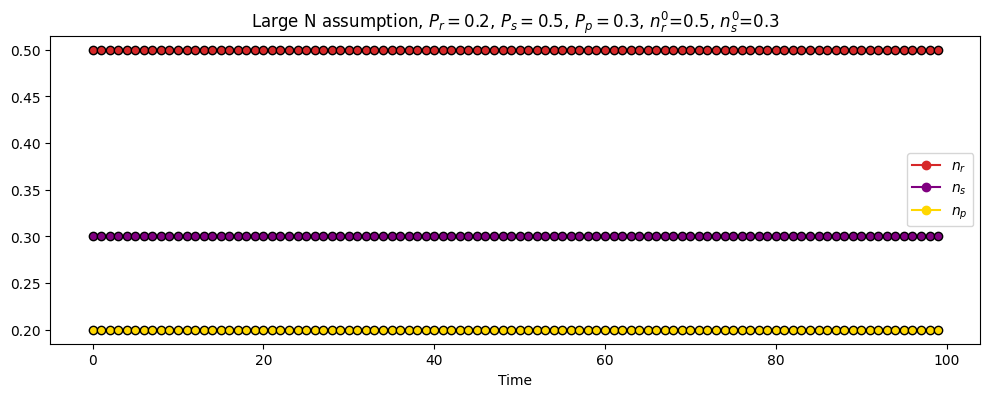

In [11]:
line_plot_species_evolution(
    fp_large_N_df,
    title='Large N assumption, $P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=0.5, $n_s^0$=0.3'
)

Initializing the population densities equal to the fixed point ($n_r=1/3$, $n_s=1/3$, $n_p=1/3), the system remains at the fixed point.

Simulating the evolution of the system under the large N assumption with $P_r = 0.2$, $P_s = 0.5$, $P_p = 0.3$, initialized with equal population densities ($n_r=1/3$, $n_s=1/3$, $n_p=1/3$) and using $\Delta_t=1$:

In [12]:
eq_large_N_df = simulate_large_N(Pr=0.2, Ps=0.5, Pp=0.3, nr_init=1/3, ns_init=1/3, delta_t=1, epochs=1000)

Plotting the evolution of the system:

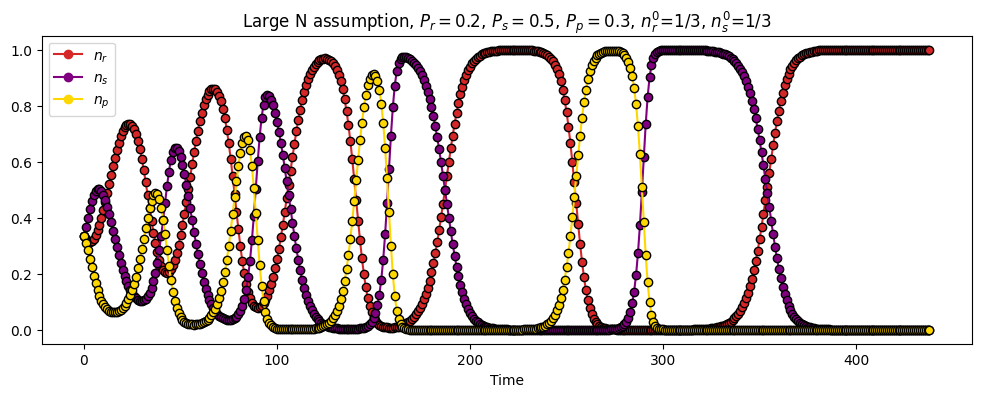

In [13]:
line_plot_species_evolution(
    eq_large_N_df,
    title='Large N assumption, $P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=1/3, $n_s^0$=1/3'
)

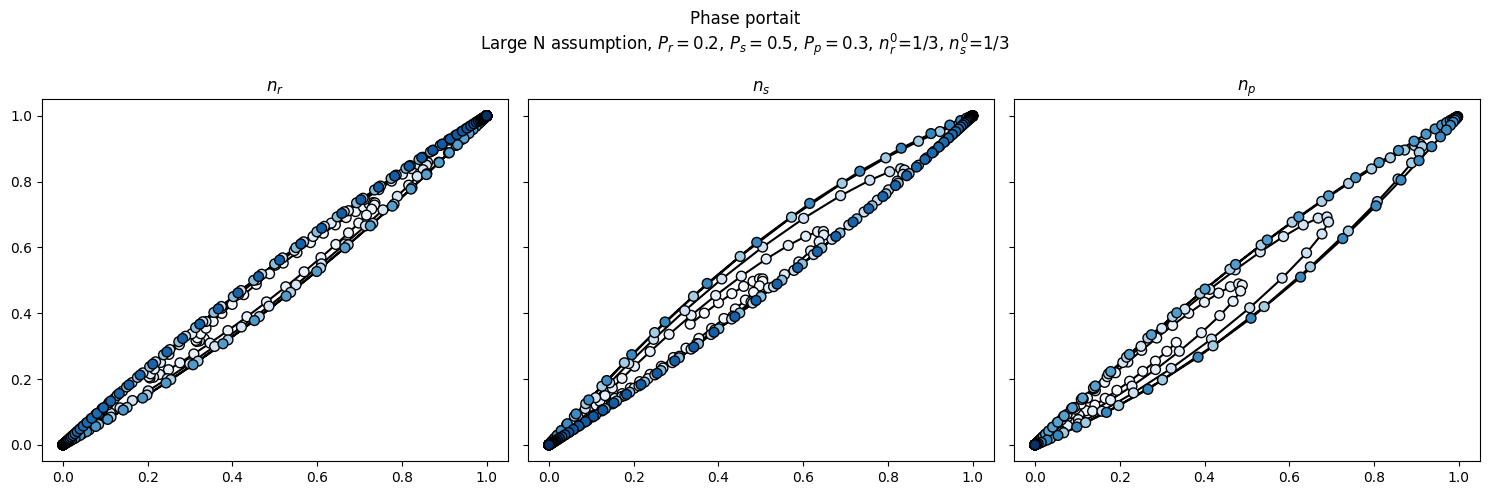

In [14]:
phase_plot_species_evolution(
    eq_large_N_df,
    title='Phase portait\nLarge N assumption, $P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=1/3, $n_s^0$=1/3'
)

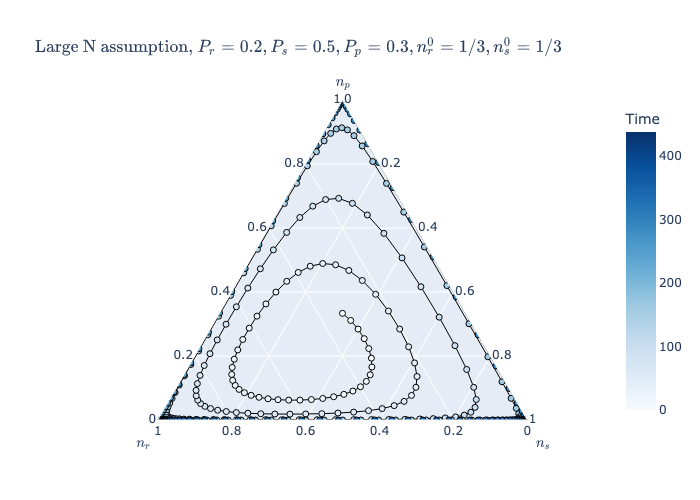

In [15]:
ternary_plot_species_evolution(
    eq_large_N_df,
    title=r"$\text{Large N assumption, }P_r=0.2, P_s=0.5, P_p=0.3, n_r^0=1/3, n_s^0=1/3$"
)

Simulating the evolution of the system with $\Delta_t=0.01$ to increase accuracy:

In [16]:
eq_large_N_df = simulate_large_N(Pr=0.2, Ps=0.5, Pp=0.3, nr_init=1/3, ns_init=1/3, delta_t=0.01, epochs=100000)

Plotting the evolution of the system:

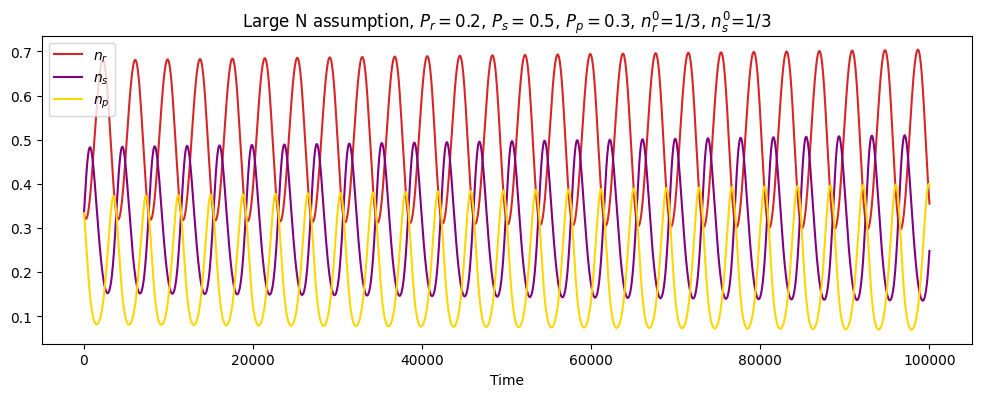

In [17]:
line_plot_species_evolution(
    eq_large_N_df,
    title='Large N assumption, $P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=1/3, $n_s^0$=1/3',
    show_markers=False
)

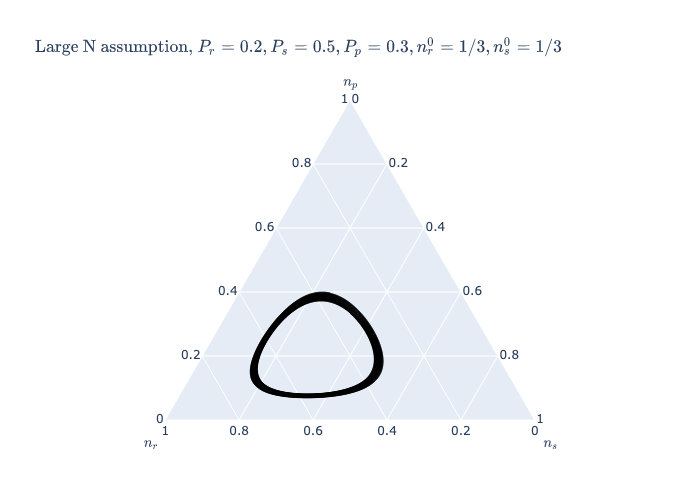

In [18]:
ternary_plot_species_evolution(
    eq_large_N_df,
    title=r"$\text{Large N assumption, }P_r=0.2, P_s=0.5, P_p=0.3, n_r^0=1/3, n_s^0=1/3$",
    show_markers=False
)

In the limit that the total number of sites is large the populations move along a periodic orbit around the fixed point.

## Continuous-time model

To enhance accuracy, we simulate the system's evolution by solving the differential equations that define it.

The `odeint` method from `scipy.integrate` solves a system of ordinary differential equations using lsoda from the FORTRAN library odepack. This library uses the Adams/BDF method with automatic stiffness detection and switching.

In [19]:
def ODE_solver(t, P, x0):
    '''
    Solve the initial value problem for the ODE system.
    '''
    def RSP(x, t, P):
        nr = x[0]
        Pr = P[0]
        ns = x[1]
        Ps = P[1]
        np = 1 - nr - ns
        Pp = P[2]

        d_nr_dt = nr*(ns*Pr - np*Pp)
        d_ns_dt = ns*(np*Ps - nr*Pr)
        return [d_nr_dt, d_ns_dt]

    y = odeint(RSP, x0, t, args=(P,))
    results_df = pd.DataFrame(y, columns=['$n_r$', '$n_s$'])
    results_df['$n_p$'] = 1 - results_df['$n_r$'] - results_df['$n_s$']
    return results_df

def simulate_continuous(t, Pr, Ps, Pp, nr_init, ns_init):
    '''
    Simulate the evolution of a population of three species over time in the
    continuous setting, solving the initial value problem for the ODE system.
    '''
    if nr_init + ns_init > 1:
        raise ValueError('Initial species proportions must be less than 1')
    
    def check_P(P):
        if P < 0 or P > 1:
            raise ValueError('P_r, P_s and P_p must be between 0 and 1')
        
    check_P(Pr)
    check_P(Ps)
    check_P(Pp)

    P = [Pr, Ps, Pp]
    x0 = [nr_init, ns_init]
    s = ODE_solver(t, P, x0)
    return s

Simulating the evolution of the system in the continuous setting with $P_r = 0.2$, $P_s = 0.5$, $P_p = 0.3$ initialized with population densities close to the fixed point ($n_r=0.5$, $n_s=0.3$, $n_p=0.2$):

In [20]:
fp_continuous_df = simulate_continuous(t=np.linspace(0,100,101), Pr=0.2, Ps=0.5, Pp=0.3, nr_init=0.5, ns_init=0.3)

Plotting the evolution of the system:

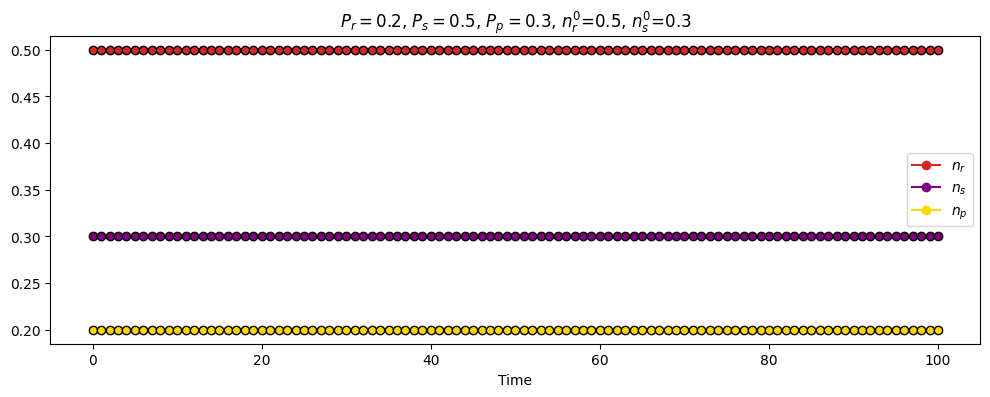

In [21]:
line_plot_species_evolution(
    fp_continuous_df,
    title='$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=0.5, $n_s^0$=0.3'
)

As in the discrete time setting, initializing the population densities equal to the fixed point ($n_r=1/3$, $n_s=1/3$, $n_p=1/3), the system remains at the fixed point.

Simulating the evolution of the system in the continuous setting with $P_r = 0.2$, $P_s = 0.5$, $P_p = 0.3$, initialized with equal population densities ($n_r=1/3$, $n_s=1/3$, $n_p=1/3$)$:

In [22]:
eq_continuous_df = simulate_continuous(t=np.linspace(0,1000,1001), Pr=0.2, Ps=0.5, Pp=0.3, nr_init=1/3, ns_init=1/3)

Plottting the evolution of the system:

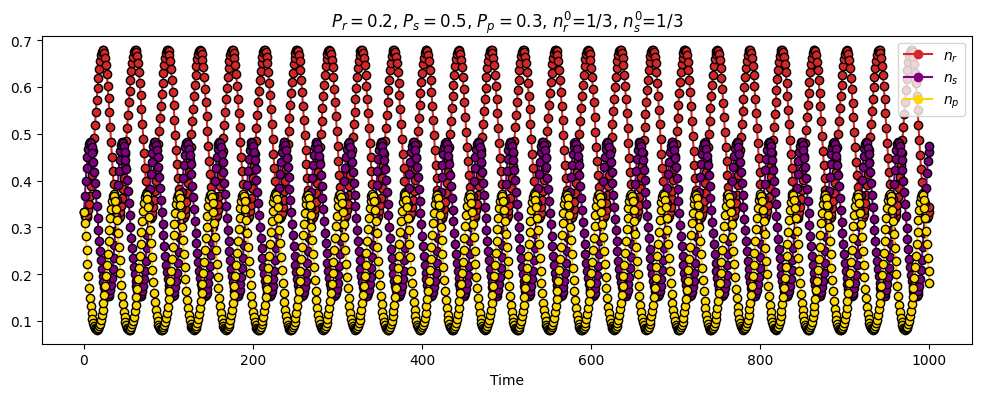

In [23]:
line_plot_species_evolution(
    eq_continuous_df,
    title='$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=1/3, $n_s^0$=1/3'
)

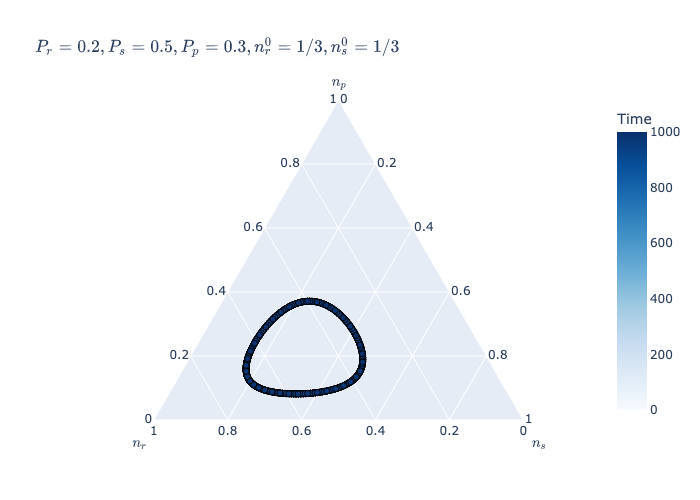

In [24]:
ternary_plot_species_evolution(
    eq_continuous_df,
    title=r"$P_r=0.2, P_s=0.5, P_p=0.3, n_r^0=1/3, n_s^0=1/3$"
)

Again, the populations move along a periodic orbit around the fixed point.

Performing simulations for different initial population densities and plotting the orbits on a ternary plot:

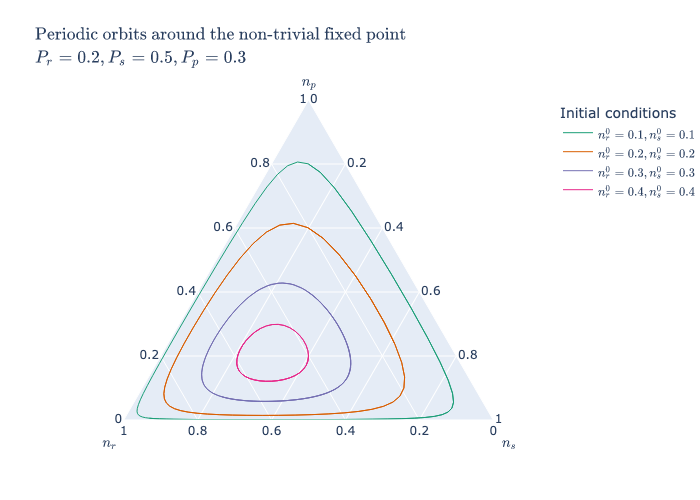

In [25]:
fig = go.Figure()
# iterating over initial proportions
for i, init in enumerate([0.1, 0.2, 0.3, 0.4]):
    # simulate the system
    df = simulate_continuous(t=np.linspace(0,100,101), Pr=0.2, Ps=0.5, Pp=0.3, nr_init=init, ns_init=init)
    # plot the trajectory
    fig.add_trace(go.Scatterternary(
        mode='lines',
        a=df['$n_p$'],
        b=df['$n_r$'],
        c=df['$n_s$'],
        name=f'$n_r^0={init}, n_s^0={init}$',
        line=dict(color=px.colors.qualitative.Dark2[i], width=1)
    ))
fig.update_layout(
    ternary=dict(
        aaxis_title='$n_p$',
        baxis_title='$n_r$',
        caxis_title='$n_s$'
    ),
    title=r"$\text{Periodic orbits around the non-trivial fixed point}\\P_r=0.2, P_s=0.5, P_p=0.3$",
    legend=dict(
        title='Initial conditions'
    )
)
fig.show('png')

The quantity $\lambda=(\frac{n_r}{R})^R(\frac{n_s}{S})^S(\frac{n_p}{P})^P$ is invariant along each orbit, with $\lambda=1$ when the populations are at the fixed point and $\lambda=0$ when one or more of the species become extinct. 

Defining a function to calculate the invariant:

In [26]:
def compute_lambda(df, Pr, Ps, Pp):
    df['lambda'] = (df['$n_r$']/0.5)**Ps*(df['$n_s$']/Pp)**Pp*(df['$n_p$']/Pr)**Pr
    return df

Computing and plotting the orbit invariant:

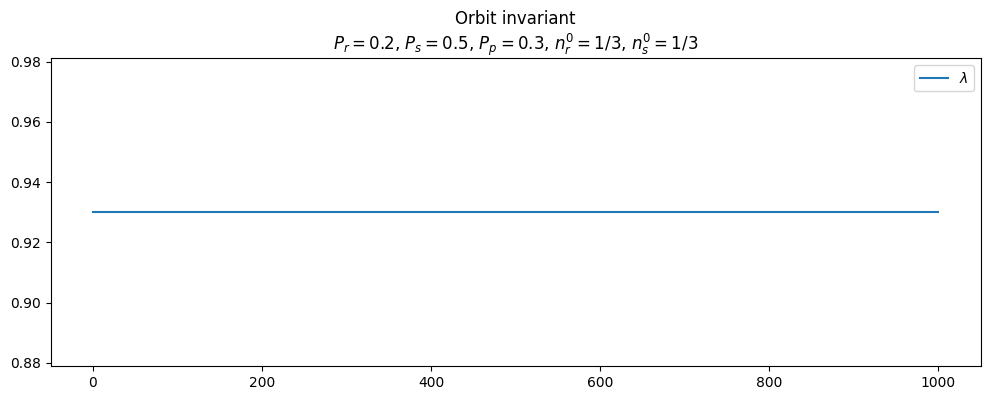

In [27]:
eq_continuous_df = compute_lambda(eq_continuous_df, Pr=0.2, Ps=0.5, Pp=0.3)
eq_continuous_df['lambda'].apply(lambda x: round(x, 2)).plot(
    figsize=(12,4),
    y='lambda',
    style='-', label='$\lambda$',
    title='Orbit invariant\n$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0=1/3$, $n_s^0=1/3$'
)
plt.legend()

In [28]:
results_df = simulate_continuous(t=np.linspace(0,500,501), Pr=0.1, Ps=0.1, Pp=0.8, nr_init=1/3, ns_init=1/3)

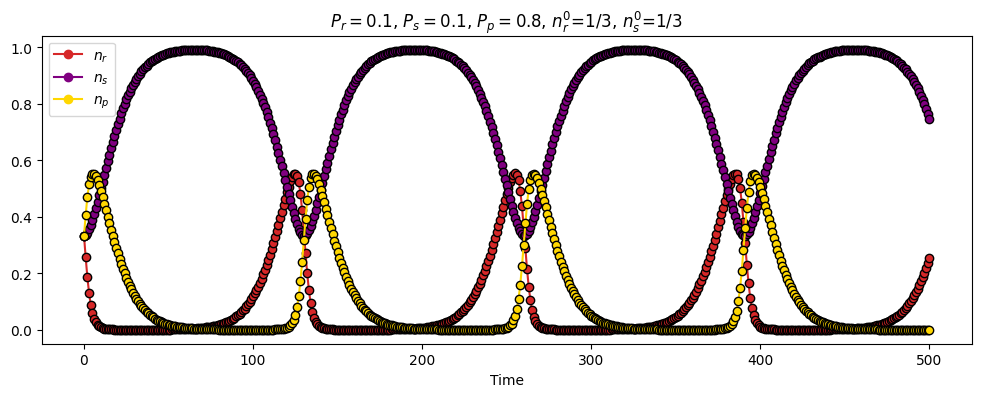

In [29]:
line_plot_species_evolution(
    results_df,
    title='$P_r=0.1$, $P_s=0.1$, $P_p=0.8$, $n_r^0$=1/3, $n_s^0$=1/3'
)

## Stochastic Simulation of Chemical Reactions

To perform stochastic simulations, we need to translate the ODE system

\begin{cases}
\frac{\partial n_r}{\partial t}=\textcolor{violet}{n_r\cdot n_s\cdot P_r} - \textcolor{gold}{n_r \cdot n_p \cdot P_p}\\
\frac{\partial n_s}{\partial t}=\textcolor{cyan}{n_s\cdot n_p\cdot P_s} - \textcolor{orange}{n_s\cdot n_r \cdot P_r}\\
\frac{\partial n_p}{\partial t}=\textcolor{palegreen}{n_p\cdot n_r\cdot P_p} - \textcolor{red}{n_p\cdot n_s \cdot P_s}\\
\end{cases}

into a system of chemical reactions, by constructing one reaction for each term of the equations as follows

\begin{cases}
\textcolor{violet}{R + S \xrightarrow{P_r} S + 2R}\\
\textcolor{gold}{R + P \xrightarrow{P_p} P}\\
\textcolor{cyan}{S + P \xrightarrow{P_s} P + 2S}\\
\textcolor{orange}{S + R \xrightarrow{P_r} R}\\
\textcolor{palegreen}{P + R \xrightarrow{P_p} R + 2P}\\
\textcolor{red}{P + S \xrightarrow{P_s} S}\\
\end{cases}

where we use the capital letters $R, S, P$ to denote the species rock, scissors and paper respectively.

We can simplify the system by noting, for example, that the terms $\textcolor{violet}{n_r\cdot n_s\cdot P_r}$ and $\textcolor{orange}{n_s\cdot n_r \cdot P_r}$ can be represented by the same reaction. Hence we can combine them into a single reaction and do the same for the other similar terms, obtaining the following system

\begin{cases}
R + S \xrightarrow{P_r} 2R\\
S + P \xrightarrow{P_s} 2S\\
P + R \xrightarrow{P_p} 2P\\
\end{cases}

The simplified system clearly represents the interactions between the species: rocks beat scissors with probability $P_r$, scissors beat paper with probability $P_s$ and paper beats rock with probability $P_p$. 

We will use StochPy, a Python package for stochastic simulation of chemical reactions:

In [30]:
import stochpy


#######################################################################
#                                                                     #
#            Welcome to the interactive StochPy environment           #
#                                                                     #
#######################################################################
#  StochPy: Stochastic modeling in Python                             #
#  http://stochpy.sourceforge.net                                     #
#  Copyright(C) T.R Maarleveld, B.G. Olivier, F.J Bruggeman 2010-2015 #
#  DOI: 10.1371/journal.pone.0079345                                  #
#  Email: tmd200@users.sourceforge.net                                #
#  VU University, Amsterdam, Netherlands                              #
#  Centrum Wiskunde Informatica, Amsterdam, Netherlands               #
#  StochPy is distributed under the BSD licence.                      #
###############################################################

StochPy uses the [PySCeS MDL](https://stochpy.sourceforge.net/html/inputfile_doc.html#pysces-inputfile), an ASCII text based input file to describe a system in terms of it’s stoichiometry, kinetics, compartments and parameters. We defined the system using such format and saved it in the file `./long_range_models/RSP_model_reduced.psc`:

In [31]:
!cat ./long_range_models/RSP_model_reduced.psc

# Rock Scissors Paper model

# R + S  --> 2R, Pr
# P + R --> 2P, Pp
# S + P --> 2S, Ps

R1:
    R + S > R + R
    R*S*Pr

R2:
    S + P > S + S
    S*P*Ps

R3: 
    P + R > P + P
    P*R*Pp

# Parameters
Pr = 0.2
Ps = 0.5
Pp = 0.3

# Init Values
R = 33
S = 33
P = 33


Loading the model:

In [32]:
smod = stochpy.SSA(IsQuiet=False)
smod.Model(model_file="RSP_model_reduced.psc",dir="./long_range_models/")
smod.ShowSpecies()

Info: Direct method is selected to perform stochastic simulations.
Parsing file: /Users/irenetesta/Stochpy/pscmodels/ImmigrationDeath.psc
Info: No reagents have been fixed
Parsing file: ./long_range_models/RSP_model_reduced.psc
Info: No reagents have been fixed
['R', 'S', 'P']


Setting initial conditions (close to the fixed point) and parameters, using a high number of copies for each species to approximate the deterministic behavior of the system:

In [33]:
smod.ChangeParameter("Pr", 0.2)
smod.ChangeParameter("Ps", 0.5)
smod.ChangeParameter("Pp", 0.3)
smod.ChangeInitialSpeciesCopyNumber("R", 50000)
smod.ChangeInitialSpeciesCopyNumber("S", 30000)
smod.ChangeInitialSpeciesCopyNumber("P", 20000)

The method to perform a stochastic simulation is `DoStochSim`:

In [34]:
help(smod.DoStochSim)

Help on method DoStochSim in module stochpy.modules.StochSim:

DoStochSim(end=False, mode=False, method=False, trajectories=False, epsilon=0.03, IsTrackPropensities=False, rate_selection=None, species_selection=None, IsOnlyLastTimepoint=False, critical_reactions=[], reaction_orders=False, species_HORs=False, species_max_influence=False, quiet=False) method of stochpy.modules.StochSim.SSA instance
    Run a stochastic simulation for until `end` is reached. This can be either time steps or end time (which could be a *HUGE* number of steps).
    
    Input:
     - *end* [default=1000] (float) simulation end (steps or time)
     - *mode* [default='steps'] (string) simulation mode, can be one of: ['steps','time']
     - *method* [default='Direct'] (string) stochastic algorithm ['Direct', 'FRM', 'NRM', 'TauLeap']
     - *trajectories* [default = 1] (integer)
     - *epsilon* [default = 0.03] (float) parameter for the tau-leap method
     - *IsTrackPropensities* [default = False]
     - *rate

In the following, we will only use the Direct method as its variants are designed to reduce computational costs, which is not a concern for the simulations we will perform.

Performing a stochastic simulation using default parameters:

Info: 1 trajectory is generated
simulation done!               
Info: Number of time steps 1000 End time 1.0951329075756742e-06
Info: Simulation time 0.00804


/Users/irenetesta/anaconda3/envs/stochpy/lib/python3.11/site-packages/stochpy/modules/Analysis.py:479: UserWarning:

linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.



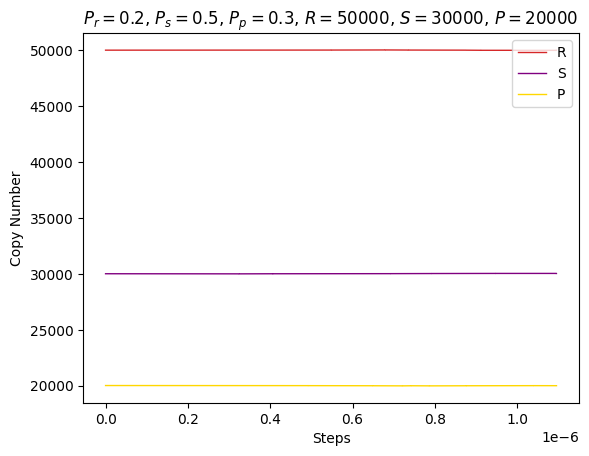

In [35]:
smod.DoStochSim()
smod.PlotSpeciesTimeSeries(colors=["tab:red", "purple", "gold"], xlabel="Steps")
stochpy.plt.title("$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $R=50000$, $S=30000$, $P=20000$");

As in deterministic simulations, using a high number of molecules and initializing species copy number close to the fixed point, ensures that the system remains at the fixed point.

Performing a stochastic simulation with a lower number of molecules and tracking reaction propensities:

In [36]:
smod.ChangeInitialSpeciesCopyNumber("R", 50)
smod.ChangeInitialSpeciesCopyNumber("S", 30)
smod.ChangeInitialSpeciesCopyNumber("P", 20)
smod.DoStochSim(end=10000, IsTrackPropensities=True)
fp_stoch_df = pd.DataFrame(smod.data_stochsim.species, columns=['R', 'S', 'P'])

Info: 1 trajectory is generated
simulation done!               
Info: Number of time steps 1928 End time 2.519492477708811
Info: Simulation time 0.03831


Plotting the evolution of the system:

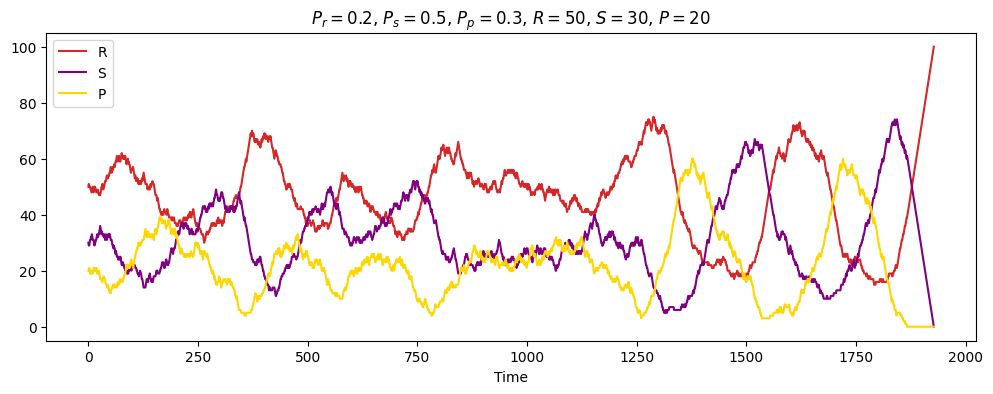

In [37]:
line_plot_species_evolution(
    fp_stoch_df,
    title="$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $R=50$, $S=30$, $P=20$",
    show_markers=False
)

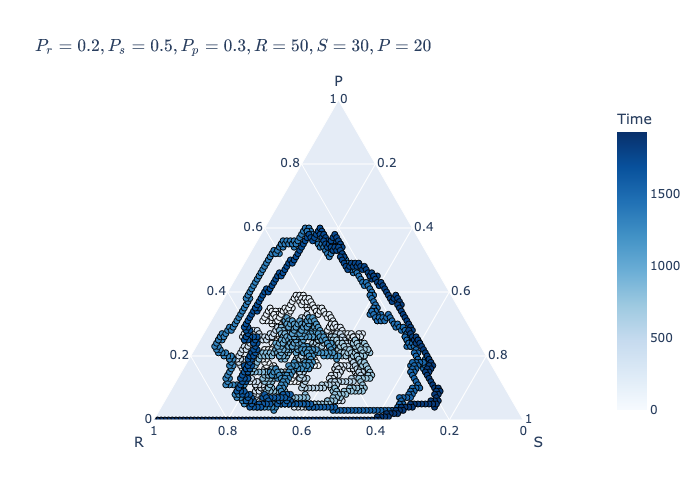

In [38]:
ternary_plot_species_evolution(
    fp_stoch_df,
    title=r"$P_r=0.2, P_s=0.5, P_p=0.3, R=50, S=30, P=20$",
)

With fewer molecules, two species (scissors and paper) eventually become extinct, and the species that survives (rock) is the one that has the lowest invasion rate, similarly to the discrete-time model with a finite number of sites.

Visualizing reaction propensities:

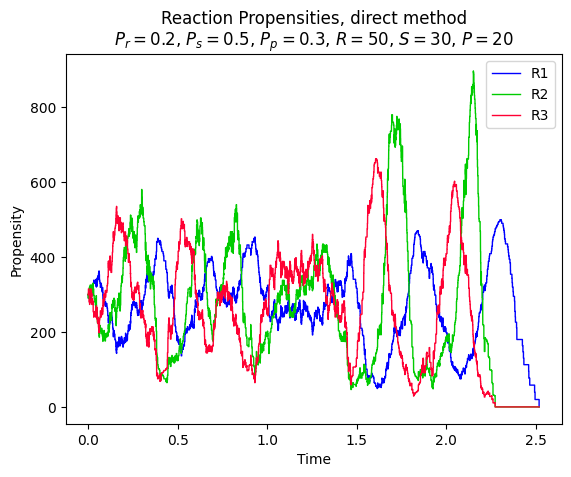

In [39]:
smod.PlotPropensitiesTimeSeries(title='Reaction Propensities, direct method\n$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $R=50$, $S=30$, $P=20$')

Plotting the time between two subsequent firings of a reaction:

Reaction	Mean
R1	0.004
R2	0.004
R3	0.004


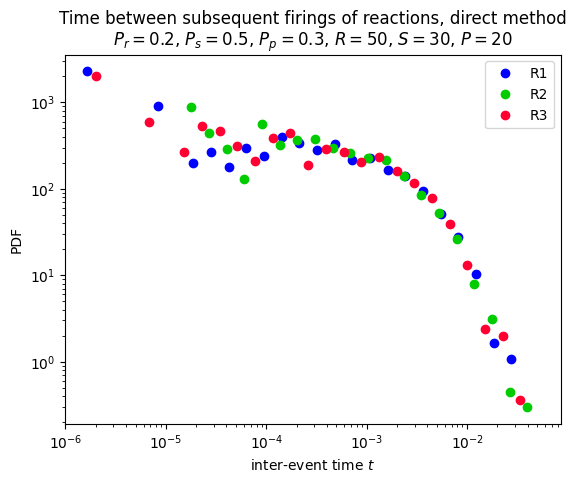

In [40]:
smod.PlotWaitingtimesDistributions(title='Time between subsequent firings of reactions, direct method\n$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $R=50$, $S=30$, $P=20$')
smod.PrintWaitingtimesMeans()

The three reactions have the same average time between two subsequent firings.

To approximate the deterministic behavior we can either perform multiple stochastic simulations and average the species copy numbers at each time point:

Info: 100 trajectories are generated
Info: Time simulation output of the trajectories is stored at RSP_model_reduced(trajectory).dat in directory: /Users/irenetesta/Stochpy/temp
Info: Simulation time: 0.41000890731811523                                                   *** WARNING ***: No regular grid is created yet. Use GetRegularGrid(n_samples) if averaged results are unsatisfactory (e.g. more or less 'samples')


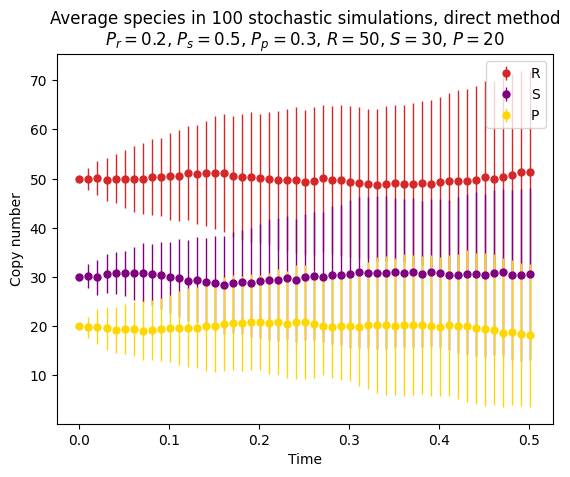

In [41]:
smod.DoStochSim(end=500, trajectories=100)
smod.PlotAverageSpeciesTimeSeries(
    colors=["tab:red", "purple", "gold"],
    title="Average species in 100 stochastic simulations, direct method\n$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $R=50$, $S=30$, $P=20$")

To get an accurate prediction of the species distribution StochPy provides the function `DoCompleteStochSim()` that continues the simulation until the first four moments converge within a user-specified error:

Info: 100000 time steps simulated
Info: 200000 time steps simulated
Info: 300000 time steps simulated
Info: 400000 time steps simulated
Info: 500000 time steps simulated
Info: 600000 time steps simulated
Info: 700000 time steps simulated
Info: 800000 time steps simulated
Info: 900000 time steps simulated
Info: 1000000 time steps simulated
Info: 1100000 time steps simulated
Info: 1200000 time steps simulated
Info: 1300000 time steps simulated
Info: 1400000 time steps simulated
Info: 1500000 time steps simulated
Info: 1600000 time steps simulated
Info: 1700000 time steps simulated
Info: 1800000 time steps simulated
Info: 1900000 time steps simulated
Info: 2000000 time steps simulated
Info: 2100000 time steps simulated
Info: 2200000 time steps simulated
Info: 2300000 time steps simulated
Info: 2400000 time steps simulated
Info: 2500000 time steps simulated
Info: 2600000 time steps simulated
Info: 2700000 time steps simulated
Info: 2800000 time steps simulated
Info: 2900000 time steps simu

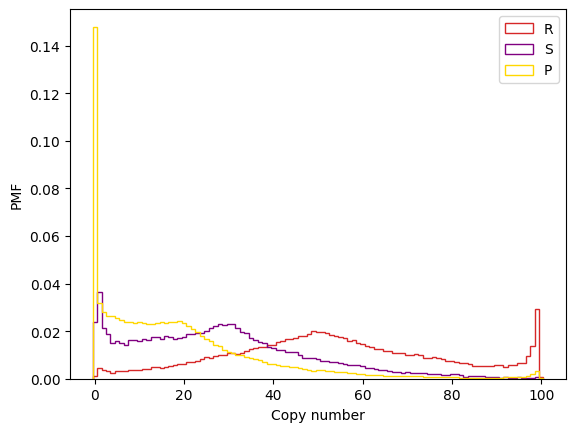

In [42]:
smod.DoCompleteStochSim()
smod.PlotSpeciesDistributions(
    colors=["tab:red", "purple", "gold"],
    title="Species distribution, direct method\n$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $R=50$, $S=30$, $P=20$")

Species $p$ probability mass is concentrated at lower values, while species $r$ and $s$ have a more uniform distribution.

Computing mean and standard deviation of the species copy number is not straightforward as the time between two events is not constant, thus it is necessary to track the time spent in each state for each species. This computation is implemented by the following functions:

In [43]:
smod.PrintSpeciesMeans()
smod.PrintSpeciesStandardDeviations()

Species	Mean
R	53.108
S	28.366
P	18.526
Species	Standard Deviation
R	23.734
S	19.751
P	18.520


We can also experiment with delayed reactions, consisting of an exponential waiting time as initiation step with a subsequent delay time.
We set a fixed delay of five seconds on reaction R1 ($R + S \rightarrow 2R$). This means that after R1 fires, it takes exactly five seconds before products are produced. By setting `nonconsuming_reactions=["R1"]`, reactants are consumed at completion.

*** WARNING ***: an invalid method (Direct) was selected. Switching to the Delayed Direct Method.
Info: Delayed Direct Method is selected to perform delayed stochastic simulations.
Parsing file: ./long_range_models/RSP_model_reduced.psc
Info: No reagents have been fixed
Info: 100 trajectories are generated
Info: Time simulation output of the trajectories is stored at RSP_model_reduced(trajectory).dat in directory: /Users/irenetesta/Stochpy/temp
Info: Simulation time: 18.141482830047607                                                   *** WARNING ***: No regular grid is created yet. Use GetRegularGrid(n_samples) if averaged results are unsatisfactory (e.g. more or less 'samples')


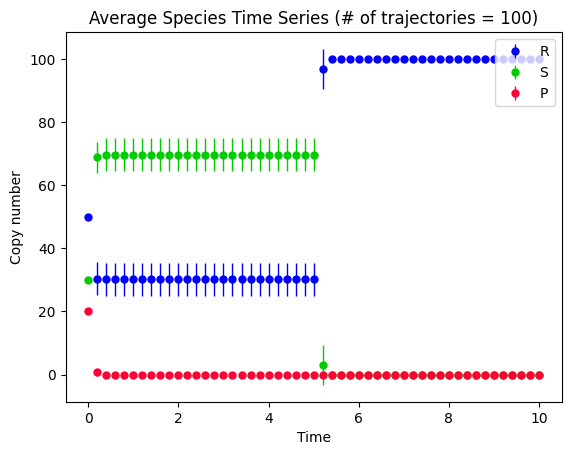

In [44]:
smod.SetDelayParameters({"R1":("fixed",5)}, nonconsuming_reactions=["R1"])
smod.DoDelayedStochSim(mode="time",end=10,trajectories=100)
smod.PlotAverageSpeciesTimeSeries()

Performing a stochastic simulation with equal initial conditions:

Info: Direct method is selected to perform stochastic simulations.
Parsing file: ./long_range_models/RSP_model_reduced.psc
Info: No reagents have been fixed
Info: 1 trajectory is generated
simulation done!               
Info: Number of time steps 469 End time 1.0884810590458118
Info: Simulation time 0.01039


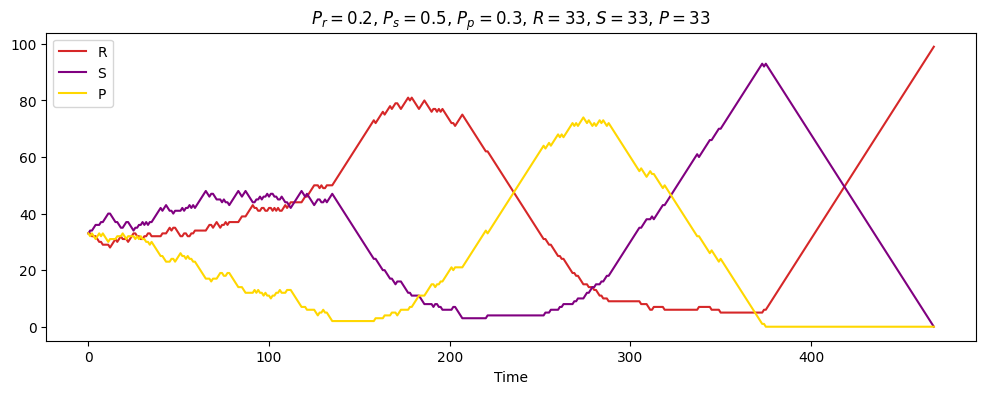

In [45]:
smod.SetDelayParameters({})
smod.ChangeInitialSpeciesCopyNumber("R", 33)
smod.ChangeInitialSpeciesCopyNumber("S", 33)
smod.ChangeInitialSpeciesCopyNumber("P", 33)
smod.DoStochSim(end=1000, method="direct")
eq_stoch_df = pd.DataFrame(smod.data_stochsim.species, columns=['R', 'S', 'P'])
line_plot_species_evolution(
    eq_stoch_df,
    title="$P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $R=33$, $S=33$, $P=33$",
    show_markers=False
)

Differently from the simulation with ODEs, the system does not exhibit oscillations, as the stochasticity of the reactions does not allow the system to reach a stable fixed point.

## Stochastic Model Checking

To perform stochastic model checking we need to translate the model into a Continuous Time Markov Chain (CTMC) and specify the properties we want to verify. Dynamical properties of the resulting CTMC could then be analyzed using the stochastic model checker [PRISM](https://www.prismmodelchecker.org). PRISM describes CTMC states through a set of bounded integer variables, hence we need to discretize the state space of the system replacing the continuous variables with bounded integer variables. This leads to the following CTMC specification in PRISM input language, where model parameters are defined by `Pr`, `Ps` and `Pp` constants (initialized with the same values used in the previous simulations), `MAX` is the discretization constant, `r`, `s` and `p` are the model variables (initialized with the densities of the species at the fixed point) and we have three transitions describing the three possible reactions:

In [46]:
!cat ./long_range_models/RSP.prism

ctmc

const double Pr = 0.2;
const double Ps = 0.5;
const double Pp = 0.3;

const int MAX = 100;

module RSP

  r : [0..MAX] init 50;
  s : [0..MAX] init 30;
  p : [0..MAX] init 20;

  [] r>0 & r<MAX & s>0 -> Pr*r*s : (r'=r+1) & (s'=s-1);
  [] s>0 & s<MAX & p>0 -> Ps*s*p : (s'=s+1) & (p'=p-1);
  [] p>0 & p<MAX & r>0 -> Pp*p*r : (p'=p+1) & (r'=r-1);

endmodule

By observing that r+s+p=1, we can simplify the model to reduce the computational times needed to verify properties by removing the variable `p`, obtaining the following PRISM input:

In [47]:
!cat ./long_range_models/RSP_reduced.prism

ctmc

const double Pr = 0.2;
const double Ps = 0.5;
const double Pp = 0.3;

const int MAX = 100;

module RSP

  r : [0..MAX] init 50;
  s : [0..MAX] init 30;

  [] r>0 & r<MAX & s>0 -> Pr*r*s : (r'=r+1) & (s'=s-1);
  [] s>0 & s<MAX & (MAX-r-s)>0 -> Ps*s*(MAX-r-s) : (s'=s+1);
  [] (MAX-r-s)>0 & (MAX-r-s)<MAX & r>0 -> Pp*(MAX-r-s)*r : (r'=r-1);

endmodule

We also need to define a list of properties to be verified, using the CSL temporal logic:

In [48]:
!cat ./long_range_models/RSP_properties.csl

P=?[ F r=0 ]

P=?[ F s=0 ]

P=?[ F (MAX-r-s)=0 ]

P=?[ F (r=70 & (F r=0)) ]

P=?[ F (s=70 & (F s=0)) ]

P=?[ F ((MAX-r-s)=70 & (F (MAX-r-s)=0)) ]

P=?[ F (MAX-r-s)=0 & s=0 ]

P=?[ F s=0 & r=0 ]

P=?[ F r=0 & (MAX-r-s)=0 ]

const int time;

P=? [ F<time r=0 ]

P=? [ F<time s=0 ]

P=? [ F<time (MAX-r-s)=0 ]

const int x;

P=? [ F=1 r>=x & r<x+10 ]

P=? [ F=1 s>=x & s<x+10 ]

P=? [ F=1 (MAX-r-s)>=x & (MAX-r-s)<x+10 ]

P=? [F<time (r=0 | r=MAX | s=0) & (s=0 | s=MAX | (MAX-r-s)=0) & ((MAX-r-s)=0 | (MAX-r-s)=MAX | r=0)]

Loading the first lines of PRISM log file:

In [49]:
!sed -n '9,128p' ./results/prism_log.txt

Type:        CTMC
Modules:     RSP
Variables:   r s

---------------------------------------------------------------------

Model checking: P=? [ F r=0 ]

Building model...

Computing reachable states...

Reachability (BFS): 121 iterations in 0.00 seconds (average 0.000000, setup 0.00)

Time for model construction: 0.124 seconds.


Type:        CTMC
States:      5151 (1 initial)
Transitions: 14853

Rate matrix: 44090 nodes (3611 terminal), 14853 minterms, vars: 14r/14c

Diagonals vector: 7997 nodes (2482 terminal), 5151 minterms
Embedded Markov chain: 72269 nodes (13625 terminal), 14853 minterms

Prob0: 100 iterations in 0.03 seconds (average 0.000310, setup 0.00)

Prob1: 99 iterations in 0.06 seconds (average 0.000626, setup 0.00)

yes = 200, no = 100, maybe = 4851

Computing remaining probabilities...
Engine: Hybrid

Building hybrid MTBDD matrix... [levels=14, nodes=72180] [3.3 MB]
Adding explicit sparse matrices... [levels=14, num=1, compact] [168.3 KB]
Creating vector for diagonals

By inspecting the log file, we can see that the model has 5151 states and 14853 transitions.

The probabilities of extinction for species r, s, and p are 0.14, 0.98, and 0.87, respectively.

Loading subsequent lines of PRISM log file:

In [50]:
!sed -n '128,278p' ./results/PRISM_log.txt

---------------------------------------------------------------------

Model checking: P=? [ F (r=70&(F r=0)) ]

Building deterministic automaton (for F ("L0"&(F "L1")))...
DFA has 3 states, 1 goal states.
Time for deterministic automaton translation: 0.03 seconds.

Constructing MC-DFA product...

Reachability (BFS): 181 iterations in 0.05 seconds (average 0.000260, setup 0.00)

States:      9806 (1 initial)
Transitions: 28340

Transition matrix: 44164 nodes (3611 terminal), 28340 minterms, vars: 16r/16c

Skipping BSCC computation since acceptance is defined via goal states...

Computing reachability probabilities...

Diagonals vector: 8037 nodes (2485 terminal), 9806 minterms
Embedded Markov chain: 72343 nodes (13625 terminal), 28340 minterms

Prob0: 208 iterations in 0.06 seconds (average 0.000303, setup 0.00)

Prob1: 99 iterations in 0.11 seconds (average 0.001101, setup 0.00)

yes = 200, no = 339, maybe = 9267

Computing remaining probabilities...
Engine: Hybrid

Building hybrid MT

The probability of a species to go extinct after having reached a density of 0.7 is 0.14 for species r, 0.65 for species s, and 0.29 for species p.

Loading subsequent lines of PRISM log file:

In [51]:
!sed -n '278,375p' ./results/PRISM_log.txt

---------------------------------------------------------------------

Model checking: P=? [ F s=0&r=0 ]

Diagonals vector: 7997 nodes (2482 terminal), 5151 minterms
Embedded Markov chain: 72269 nodes (13625 terminal), 14853 minterms

Prob0: 198 iterations in 0.05 seconds (average 0.000237, setup 0.00)

Prob1: 50 iterations in 0.01 seconds (average 0.000300, setup 0.00)

yes = 100, no = 200, maybe = 4851

Computing remaining probabilities...
Engine: Hybrid

Building hybrid MTBDD matrix... [levels=14, nodes=72180] [3.3 MB]
Adding explicit sparse matrices... [levels=14, num=1, compact] [168.3 KB]
Creating vector for diagonals... [dist=1, compact] [10.1 KB]
Creating vector for RHS... [dist=2, compact] [10.1 KB]
Allocating iteration vectors... [2 x 40.2 KB]
TOTAL: [3.6 MB]

Starting iterations...

Jacobi: 5060 iterations in 2.31 seconds (average 0.000015, setup 2.23)

Value in the initial state: 0.12484498983774625

Time for model checking: 5.309 seconds.

Result: 0.12484498983774625 (+/- 

The probability of a species outcompeting the other two species is 0.12 for species p, 0.02 for species s, and 0.86 for species r.

By varying the constant `time` between 1 and 10, we can plot the extinction probabilities for each species:

<img align="center" src='./results/extintion_fixed.png' width="600px">

Rock, the species with the lowest invasion rate, is the most likely to survive.

We can also plot the probability of reaching any absorbing state (a state where no further transitions are possible) within the first 6 time units:

<img align="center" src='./results/absorbing_state.png' width="600px">

By binning the number of individuals in disjoint intervals (x <= number of individuals < x+10), we can plot the probabilities for each species being in a certain interval at time t=1:

<img align="center" src='./results/individuals_fixed.png' width="600px">